In [1]:
%run -i "loaddata.py"
plt.style.use('seaborn-white')
plt.style.use('seaborn-ticks')
plt.rcParams["font.size"] = 16
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
scale = False
save = True

What is your name? [Simone/Jonathan/Marcus/Runi]Jonathan


### The timeseries

In [2]:
all_keys = tuple(data_dict.keys())
keys = [all_keys[i] for i in range(len(all_keys)) if i%2==0]
features = data_dict[all_keys[1]]

# Make data_sort containing all datasets either scaled or not
data_sort = []
for key in keys:
    mask = [(data_dict[key][i,3:] != 0.).all() & (np.isnan(data_dict[key][i,3:])!=True).all() for i in range(len(data_dict[key]))]
    if scale:
        scaler = StandardScaler()
        new_d = scaler.fit_transform(data_dict[key][mask,:])
    else:
        new_d = data_dict[key][mask, :]
    data_sort.append(new_d)

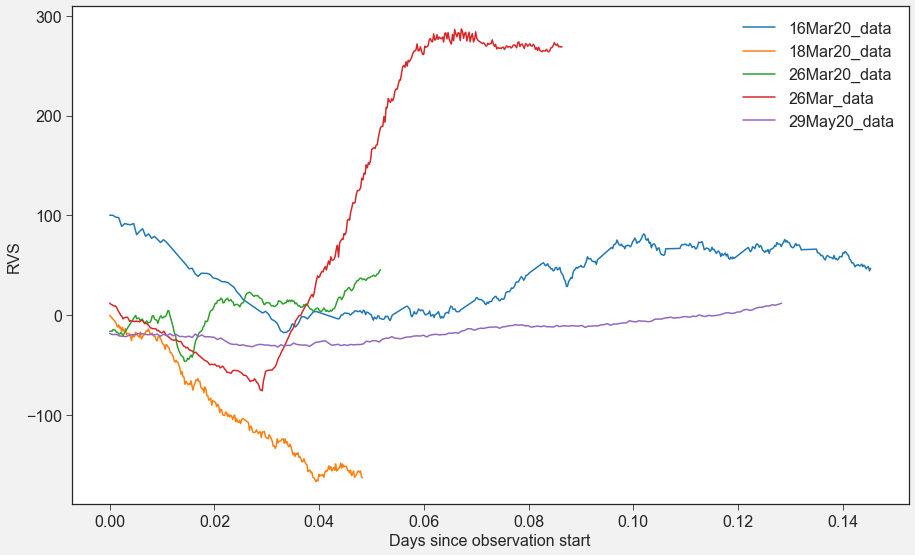

In [3]:
fig = plt.figure(figsize=(13,8))
for i in range(len(keys)):
    new_x = data_sort[i][:,0]; new_y = data_sort[i][:,1]
    new_x = new_x - min(new_x)
    plt.plot(new_x, new_y, label=keys[i])
plt.legend()
if scale:
    plt.xlabel("Scaled time"); plt.ylabel("Scaled RVS")
else:
    plt.xlabel("Days since observation start"); plt.ylabel("RVS")
fig.patch.set_facecolor("#f2f2f2") 
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f"figs/RVS_scaled_{str(scale)}.png", dpi=490, facecolor=fig.get_facecolor())

### Stacked histograms of feature distributions

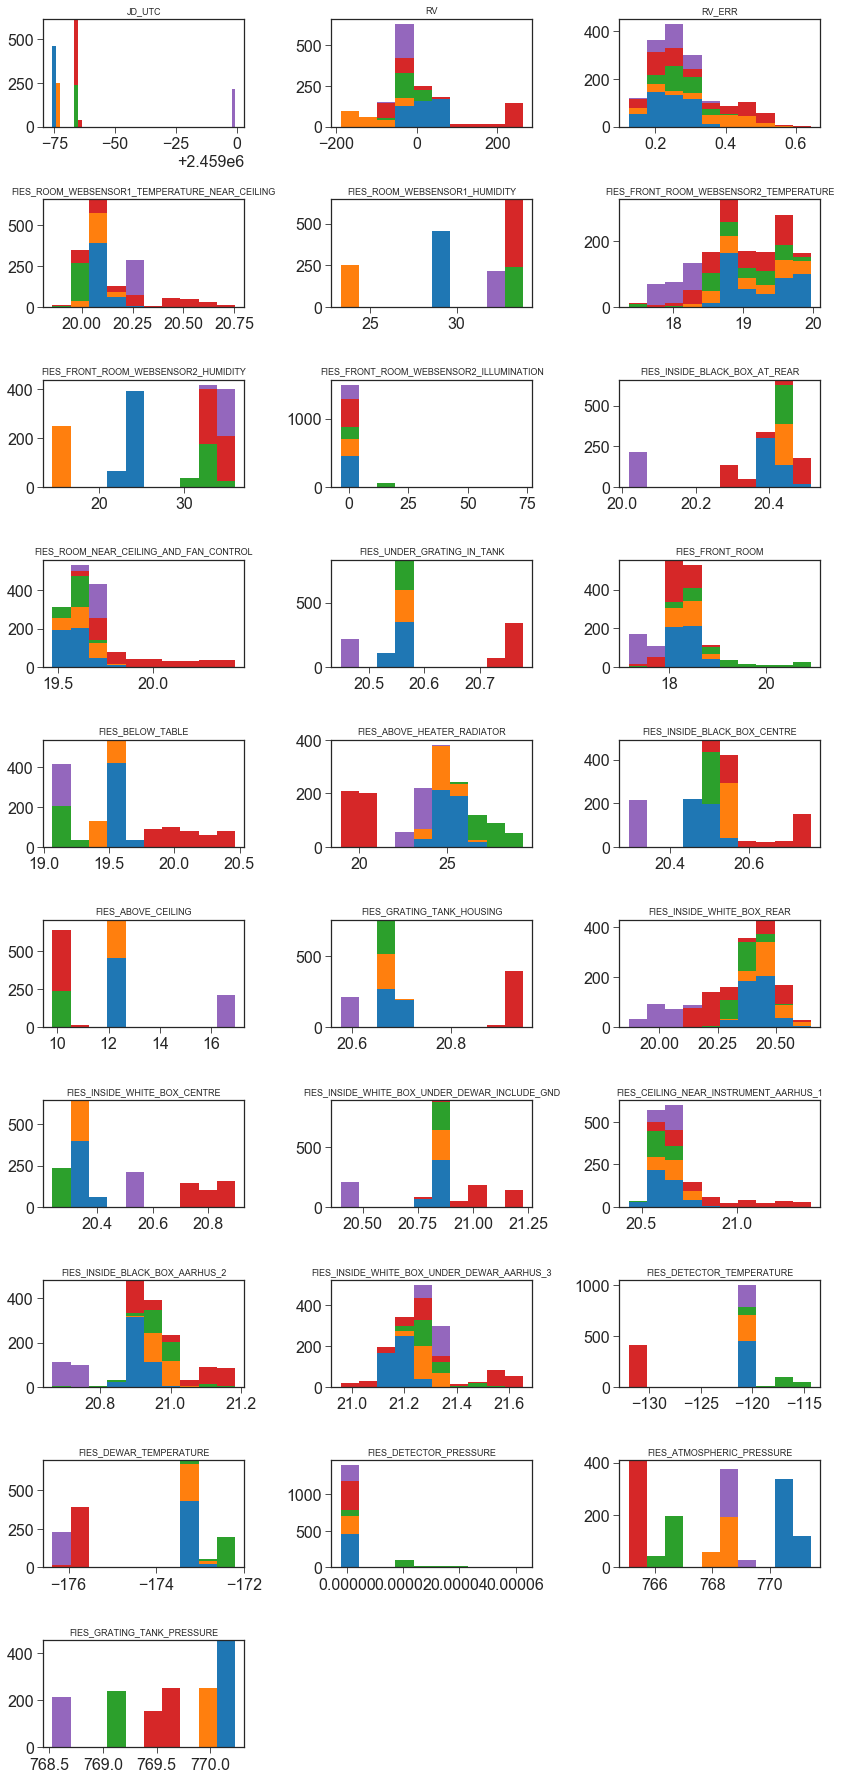

In [4]:
fig = plt.figure(figsize=(12,25))
for i in range( data_dict[keys[0]].shape[1] ):
    plt.subplot(10,3,i+1)
    plt.title(features[i], fontsize=9)
    # Mask to remove 0
    mask = [((data_dict[keys[j]][:,i] != 0.) & (np.isnan(data_dict[keys[j]][:,i]) != True)) for j in range(len(keys))]
    if i == 0:
        plt.hist([data_dict[keys[j]][mask[j],i] for j in range(len(keys))], 
                 histtype='barstacked', align='left', bins=50)
    else:
        plt.hist([data_dict[keys[j]][mask[j],i] for j in range(len(keys))], 
                 histtype='barstacked', align='left')

plt.tight_layout()
plt.show()

if save:
    fig.savefig("figs/features_hist.pdf")

### RVS correlations

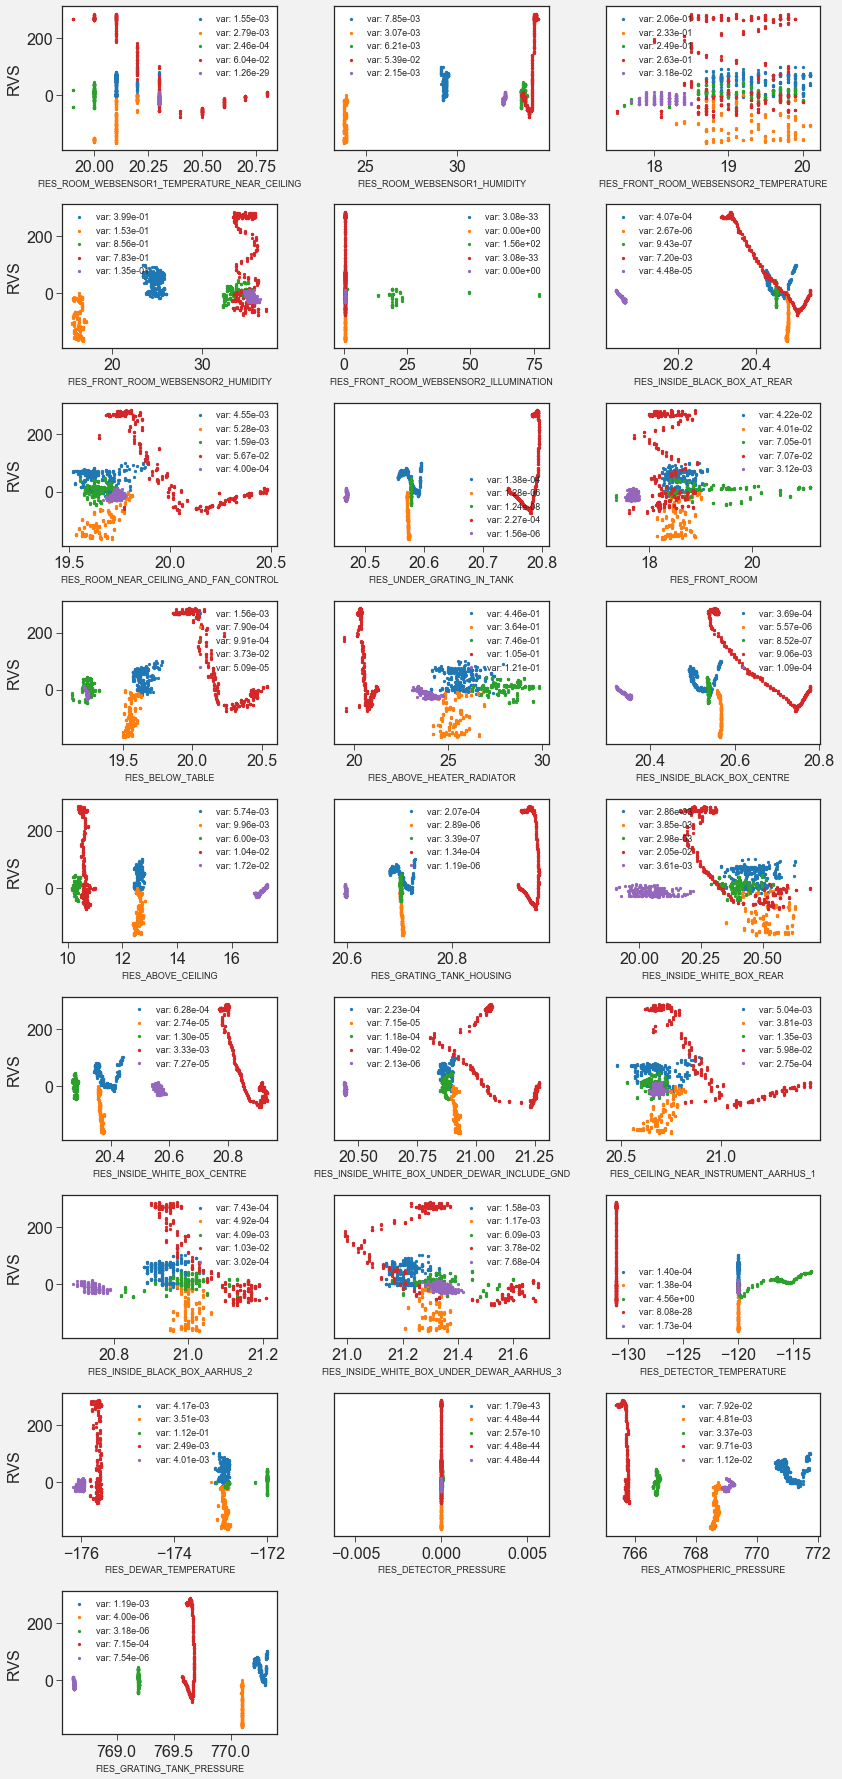

In [5]:
fig = plt.figure(figsize=(12,25))
for i in range(3,data_dict[keys[0]].shape[1]):
    plt.subplot(9,3,i-2)
    for j in range(len(keys)):
        if scale:
            plt.scatter(data_sort[j][:,i], data_sort[j][:,1], s=5)
        else:
            plt.scatter(data_sort[j][:,i], data_sort[j][:,1], s=5, label=f"var: {np.var(data_sort[j][:,i]):.2e}")
        ax = plt.gca()
        
        if i%3!=0:
            ax.axes.get_yaxis().set_visible(False)
    if i%3==0:
        plt.ylabel("RVS")
    plt.xlabel(features[i], fontsize=9) 
    if not scale:
        plt.legend(fontsize=9)
fig.patch.set_facecolor("#f2f2f2") 
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f"figs/correlations_scaled_{str(scale)}.pdf", facecolor=fig.get_facecolor())

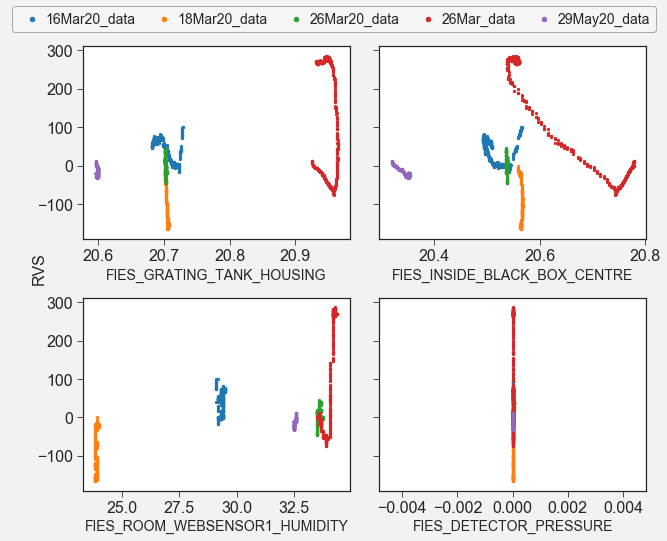

In [6]:
chosen_features = ['FIES_GRATING_TANK_HOUSING', "FIES_INSIDE_BLACK_BOX_CENTRE", "FIES_ROOM_WEBSENSOR1_HUMIDITY", "FIES_DETECTOR_PRESSURE"]
fig, axs = plt.subplots(2,2, figsize=(10,8), sharey=True)
for i, feat in enumerate(chosen_features):
    ax = axs[i//2, i%2]
    for j in range(len(keys)):
        ind = [k for k in range(len(features)) if features[k]==feat][0]
        ax.scatter(data_sort[j][:,ind], data_sort[j][:,1], s=5, label=keys[j])
    ax.set_xlabel(feat, fontsize=14) 

handles, labels = ax.get_legend_handles_labels()

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none',top=False, bottom=False, left=False, right=False)
plt.ylabel("RVS")
fig.patch.set_facecolor("#f2f2f2") 
plt.tight_layout()
fig.subplots_adjust(top=0.92)
lgnd = fig.legend(handles, labels, loc='upper center', ncol=5, edgecolor='k', framealpha=.3, frameon=True, columnspacing=1.
                 , markerscale=2, handletextpad=0, fontsize=14)
plt.show()

if save:
    fig.savefig(f"figs/4plot_correlation_scaled_{str(scale)}.png", dpi=500, facecolor=fig.get_facecolor())

### Parameters vs. time

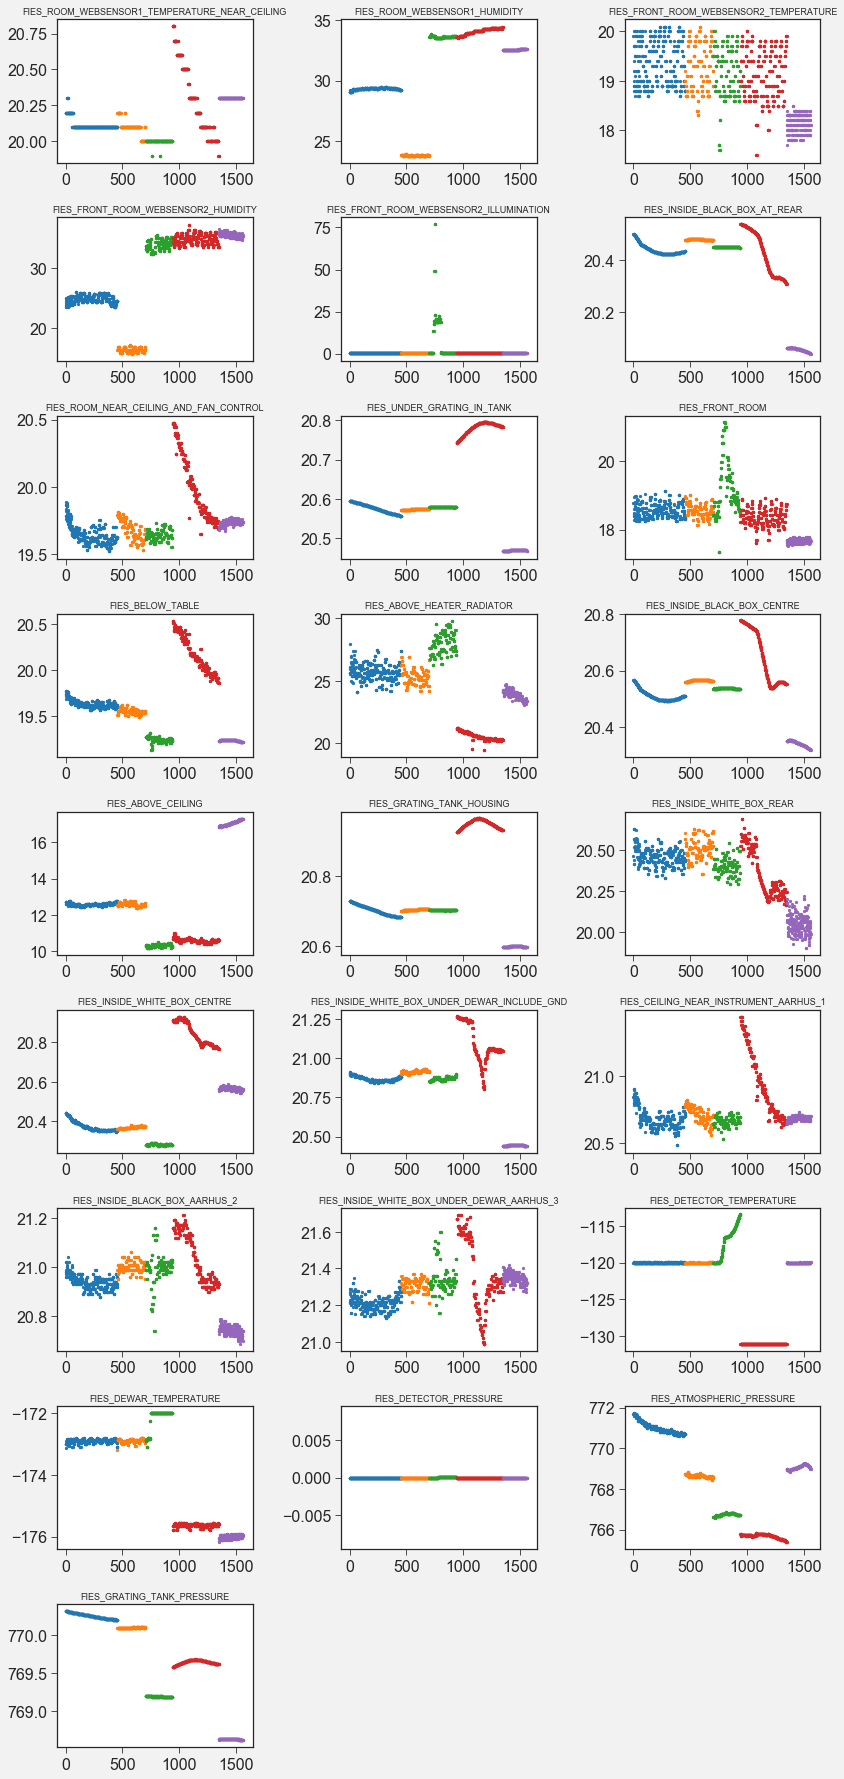

In [7]:
l = [len(data_sort[i]) for i in range(len(keys))]
x = []
for i in range(len(keys)):
    x.append(np.arange(sum(l[:i]), sum(l[:i+1])))

fig = plt.figure(figsize=(12,25))
for i in range(3,data_dict[keys[0]].shape[1]):
    plt.subplot(9,3,i-2)
    for j in range(len(keys)):
        plt.scatter(x[j], data_sort[j][:,i], s=5)
        ax = plt.gca()

    plt.title(features[i], fontsize=9)
fig.patch.set_facecolor("#f2f2f2") 
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f"figs/parameter_vs_time_scaled_{str(scale)}.pdf", facecolor=fig.get_facecolor())

### Analysis of RVS values for the same temperature/pressure timestamp

In [8]:
# Clean and put into data_sort
data_sort = []
for key in keys:
    pre_data = []
    for i in range( len(data_dict[key]) ):
        if ( (data_dict[key][i,3:] != 0.).all() ) & ( (np.isnan(data_dict[key][i, :])!=True).all() ):
            pre_data.append( list(data_dict[key][i,:]) )
    data_sort.append(np.array(pre_data))
print([len(i) for i in data_sort])

[456, 247, 238, 407, 211]


In [9]:
# Find how many repititions and how much variance in RVS there is
repetition = []
RVS_variance = []
for part in data_sort:
    pre_rep = []
    pre_var = []
    i = 0
    while i <= (len(part)-1):
        count = 1
        while ( (i+count)<(len(part)-1) ):
            if not (part[i, 3:] == part[i+count, 3:]).all():
                break
            count += 1
        
        if count>1:
            # Dont find variance when there is no repetition
            pre_var.append(np.var(part[i:(i+count), 1])) 
        pre_rep.append(count-1)
        i += count
    repetition.append(np.array(pre_rep))
    RVS_variance.append(np.array(pre_var))
print([sum(i) for i in repetition])
print([len(i) for i in repetition])
print([len(i) for i in RVS_variance])

[280, 177, 165, 283, 27]
[176, 70, 73, 124, 184]
[131, 68, 72, 123, 27]


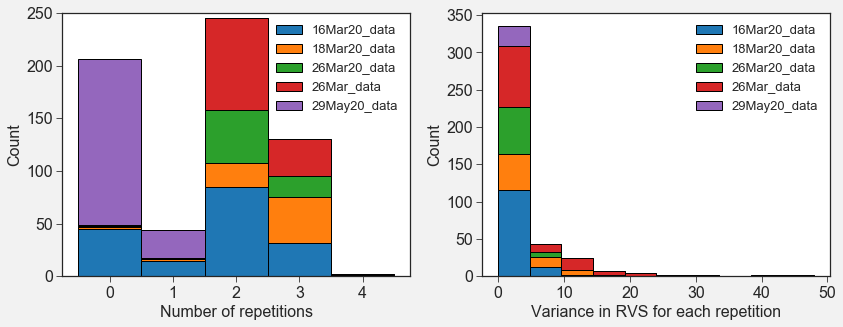

In [10]:
bins = np.arange(-0.5, 5.5, 1)

fig = plt.figure(figsize=(12,5))
# plt.suptitle("Analysis of repetitions in data", fontsize=20)

plt.subplot(121)
plt.hist(repetition, bins=bins, ec='k', label=keys, histtype="barstacked")
plt.xlabel("Number of repetitions"); plt.ylabel("Count")
plt.ylim([0,250])
plt.legend(fontsize=13)

plt.subplot(122)
plt.hist(RVS_variance, ec='k', histtype='barstacked', label=keys)
plt.xlabel("Variance in RVS for each repetition"); plt.ylabel("Count")
plt.legend(fontsize=13)

fig.patch.set_facecolor("#f2f2f2")
plt.tight_layout()
plt.subplots_adjust(top=0.9) 
plt.show()

if save:
    fig.savefig("figs/repetitions.png", dpi = 600, facecolor=fig.get_facecolor())

### t-SNE

In [11]:
from sklearn.manifold import TSNE

# Collect all data in a single array
data = np.empty(( 0, data_sort[0].shape[1]))
for i in range(len(data_sort)):
    data= np.append(data, data_sort[i], axis=0)

y_labels = data[:,1]
X = data[:,3:]

tsne = TSNE(n_components = 2, n_jobs=-1, verbose=0, random_state=42)
tsne_data = tsne.fit_transform(X)

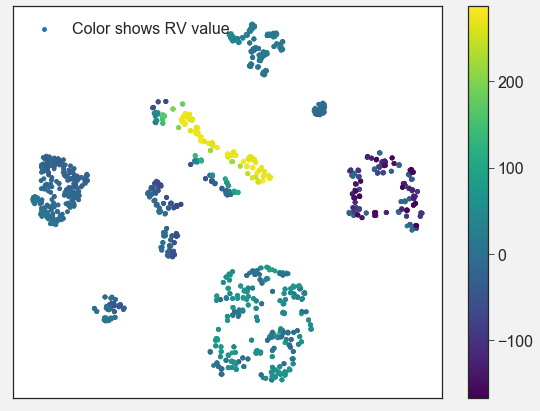

In [12]:
fig = plt.figure(figsize=(8,6))
# plt.title("t-SNE dimensionality reduction")
plt.scatter(tsne_data[:,0], tsne_data[:,1], s=15, c = y_labels, label="Color shows RV value", cmap='viridis')
# plt.xlabel("t-SNE component 1")
# plt.ylabel("t-SNE component 2")
plt.xticks([]); plt.yticks([])
plt.colorbar()
plt.legend()
fig.patch.set_facecolor("#f2f2f2")
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f"figs/t-SNE_scaled_{scale}.png", dpi=700, facecolor=fig.get_facecolor())

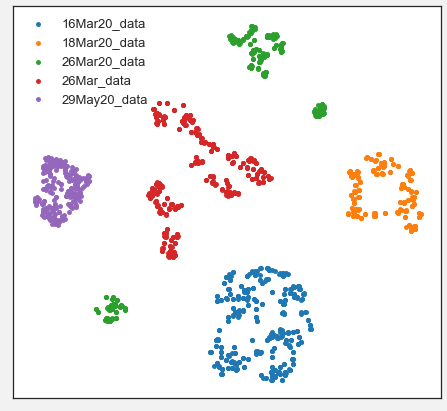

In [13]:
lengths = [len(data_sort[i]) for i in range(len(keys))]
cum_l = np.append([0],np.cumsum(lengths))

fig = plt.figure(figsize=(6.5,6))
# plt.title("t-SNE dimensionality reduction")

summ = []
for i in range(len(cum_l)-1):
    plt.scatter(tsne_data[cum_l[i]:cum_l[i+1],0], tsne_data[cum_l[i]:cum_l[i+1],1], s=15, label=keys[i])
    summ.append(len(tsne_data[cum_l[i]:cum_l[i+1],0]))
    

# plt.xlabel("t-SNE component 1")
# plt.ylabel("t-SNE component 2")
plt.xticks([]); plt.yticks([])
plt.legend(fontsize=13)
fig.patch.set_facecolor("#f2f2f2")
plt.tight_layout()
plt.show()

if save:
    fig.savefig(f"figs/t-SNE_data_difference_scaled_{scale}.png", dpi=700, facecolor=fig.get_facecolor())